In [1]:
import h5py

In [2]:
import numpy as np

In [3]:
from tabascal.jax.coordinates import orbit

In [4]:
import matplotlib.pyplot as plt

In [5]:
plt.rcParams['font.size'] = 18
plt.rcParams['font.family'] = 'serif'

In [6]:
def loadH5(h5_path, p_names=False):
    mcmc = {}
    with h5py.File(h5_path, "r") as fp:
        for key in fp.keys():
            mcmc[key] = {}
            for key2 in fp[key].keys():
                if key == "param_names":
                    if p_names:
                        mcmc[key][key2] = fp[key][key2][...].astype("unicode")
                    else:
                        continue
                else:
                    mcmc[key][key2] = fp[key][key2][...]
    return mcmc

In [7]:
def correct_vis(mcmc, track, vis_obs_cal, rfi_orbit, n_wraps=20, n_bl_avg=200):
    N_time = mcmc[track]["n_time"]
    N_int_samples = mcmc[track]["n_int_samples"]
    N_ant = mcmc[track]["n_ant"]
    N_freq = mcmc[track]["n_freq"]
    N_corr = 1
    a1 = mcmc[track]["antenna1"]
    a2 = mcmc[track]["antenna2"]
    N_bl = len(a1)
    times_fine = mcmc[track]["times_fine"]
    vis_obs = np.abs(mcmc[track]["vis_obs"]).mean(axis=(1, 2))
    # rfi_amp = (
    #     linear_extrapolate(
    #         times_fine, mcmc[track]["times"], vis_obs, N_int_samples
    #     ).reshape(N_time, N_int_samples)
    #     / vis_obs[:, None]
    # )

    # Calculate expected rfi vis phase
    rfi_xyz = orbit(times_fine, *rfi_orbit)
    distances = np.linalg.norm(mcmc[track]["ants_XYZ"] - rfi_xyz[:, None, :], axis=2)
    c_distances = (distances - mcmc[track]["ants_UVW"][..., -1])[..., None]

    rfi_vis_fine = rfi_vis(
        np.ones((N_time * N_int_samples, N_ant, 1, 1)),
        c_distances,
        mcmc[track]["freqs"]
    )[..., 0]

    # rfi_vis_fine = rfi_vis(
    #     rfi_amp.reshape(-1, 1, 1, 1) * np.ones((N_time * N_int_samples, N_ant, 1, 1)),
    #     c_distances,
    #     mcmc[track]["freqs"],
    # )[..., 0]

    # Choose baselines where the phase wrap on full track is closest to unity
    rfi_phase_uw = np.unwrap(np.angle(rfi_vis_fine), discont=0, axis=0)
    rfi_n_wraps = np.abs((rfi_phase_uw[0] - rfi_phase_uw[-1])) / (2 * np.pi)
    bl_idx = np.argsort(np.abs(rfi_n_wraps - n_wraps))

    # Estimate rfi amplitude by averaging over time on calibrated visibilities of chosen baselines
    rfi_amp_est = np.abs(
        vis_obs_cal[:, bl_idx[:n_bl_avg]]
        - vis_obs_cal[:, bl_idx[:n_bl_avg]].mean(axis=0, keepdims=True)
    ).mean(axis=-1)

    rfi_amp_est = linear_extrapolate(
        times_fine, mcmc[track]["times"], rfi_amp_est, N_int_samples
    )
    # Average down unitary rfi visibilities

    # rfi_vis_avg = rfi_vis_fine.reshape(N_time, N_int_samples, N_bl).mean(axis=1)

    # Calculate estimated rfi visibilities

    # vis_rfi_est = rfi_amp_est[:, None] * rfi_vis_avg
    
    return bl_idx[:n_bl_avg], rfi_amp_est, rfi_vis_fine

    vis_rfi_est = (
        (rfi_amp_est[:, None] * rfi_vis_fine)
        .reshape(N_time, N_int_samples, N_bl)
        .mean(axis=1)
    )

    # Calculate calibrated astronomical visibilities
    vis_corr = vis_obs_cal - vis_rfi_est  # .reshape(-1, N_freq, N_corr)

    return vis_corr

In [8]:
def calibrate_obs(gains_cal, vis_obs):
    # Calculate calibrated visibilities
    a1, a2 = np.triu_indices(len(gains_cal), 1)
    gains_cal_bl = gains_cal[a1] * gains_cal[a2].conjugate()
    vis_obs_cal = vis_obs[:, :, 0] / gains_cal_bl[None, :]
    return vis_obs_cal

In [9]:
def linear_extrapolate(x, xp, fp, N_int_samples):
    N_ext = int(N_int_samples / 2)

    xi = x[:N_ext]
    xf = x[-N_ext:]

    x_int = x[N_ext:-N_ext]
    y_int = np.interp(x_int, xp, fp)

    dyi = (y_int[1] - y_int[0]) / (x_int[1] - x_int[0])
    dyf = (y_int[-1] - y_int[-2]) / (x_int[-1] - x_int[-2])

    yi = y_int[0] + dyi * (xi - xp.min())
    yf = y_int[-1] + dyf * (xf - xp.max())

    return np.concatenate([np.array(yi), np.array(y_int), np.array(yf)])

In [10]:
def rfi_vis(app_amplitude, c_distances, freqs):
    """
    Calculate visibilities from distances to rfi sources.

    Parameters:
    -----------
    app_amplitude: np.array (n_time, n_ant, n_freq, n_src)
        Apparent amplitude at the antennas.
    c_distances: np.array (n_time, n_ant, n_src)
        The phase corrected distances between the rfi sources and the antennas.
    freqs: np.array (n_freq,)
        Frequencies.

    Returns:
    --------
    vis: np.array (n_time, n_bl, n_freq)
        The visibilities.
    """
    n_time, n_ant, n_freq, n_src = app_amplitude.shape
    c = 2.99792458e8

    # Create array of shape (n_time, n_bl, n_freq, n_src) and then sum over n_src

    minus_two_pi_over_lamda = (-2.0 * np.pi * freqs / c).reshape(1, 1, n_freq, 1)

    c_distances = c_distances.reshape(n_time, n_ant, 1, n_src)

    a1, a2 = np.triu_indices(n_ant, 1)

    phase = minus_two_pi_over_lamda * (c_distances[:, a1] - c_distances[:, a2])
    intensities_app = app_amplitude[:, a1] * app_amplitude[:, a2]

    vis = np.sum(intensities_app * np.exp(-1.0j * phase), axis=-1)

    return vis

In [11]:
def average(x, n_int):
    return x.reshape(-1, n_int).mean(axis=1)

In [12]:
mcmc = loadH5("data/imaging_dict_7min.h5")

In [13]:
vis_cal = calibrate_obs(mcmc['track1']['gains'].mean(axis=(0,2)), mcmc['track1']['vis_obs'])
bl_idx, rfi_amp_est, rfi_vis_fine = correct_vis(mcmc, 'track1', vis_cal, mcmc['track1']['rfi_orbit'])

In [15]:
bl_idx

array([ 980, 1301,  619,  671, 1631, 1437,  736,  718,  788, 1804, 1926,
       1349,   24, 1979,  104,  472,  527, 1948,   49,  730, 1841, 1131,
       1747, 1498,  695, 1408,  571,  386,   75,   10,    9, 1838,  581,
        108,  713,  546, 1235,  587,  678,  639,  626,  149, 1027, 1054,
       1860, 1775,  384, 1914, 1464,  750,  517,  462, 1294,  958, 1507,
        404,  377,  492,  437, 1399, 1395, 1849, 1630, 1634,  228, 1975,
        280,   90, 1036,  740,  844,  469,  524,   80, 1327, 1808,  753,
        976, 2014, 1957, 1138, 1880,  532,  531,   60, 1016,  797, 1217,
        824, 1492,  752,   59, 1831,  822,  578, 1655,  418, 1958,  777,
        993,  935,  744, 1345,  101, 1874, 1863, 1293, 1213, 1509,  953,
       1134, 1810,  781,  478,  423,  477, 1837, 1339, 1475, 1471, 1331,
         95, 1391,  806, 1515,  988, 1231, 1322, 1663,   22,   64, 1397,
       1859, 1632,  962, 1467,  637,  689,  387, 1624, 1898, 1024, 1142,
       1052, 1497, 1224, 1954, 1466,  582, 1245,  9

In [14]:
times_fine = mcmc['track1']['times_fine']

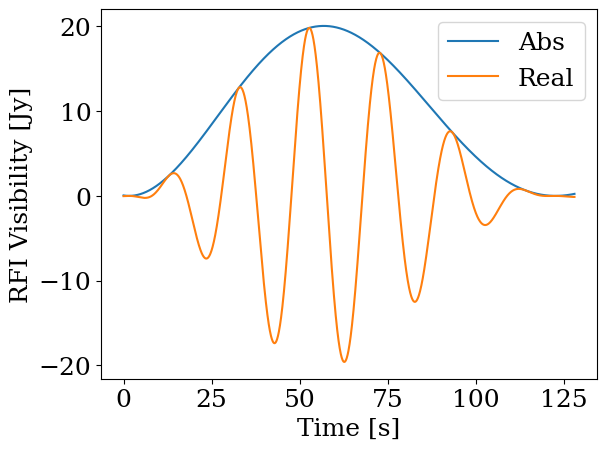

In [99]:
time = times_fine[:2048]-times_fine[0]
rfi = mcmc['track1']['vis_rfi'][:2048,bl_idx[0],0]

plt.plot(time, np.abs(rfi), label='Abs')
plt.plot(time, np.real(rfi), label='Real')
plt.xlabel('Time [s]')
plt.ylabel('RFI Visibility [Jy]')
plt.legend()

In [17]:
a1, a2 = np.triu_indices(64, 1)
uvw_a = mcmc['track1']['ants_UVW'][0,:]
uvw = uvw_a[a1] - uvw_a[a2]
mag_uvw = np.linalg.norm(uvw, axis=-1)

In [102]:
def plot_rfi_avg(times, vis_rfi, bl_idx, log=True, save=True, close=True):
    
    fig, ax = plt.subplots(1, 1, figsize=(10,7))
    #for n_int, integ in zip([1, 32, 32*15, 32*225], ['Instantaneous', '2s (Data Rate)', '30s', '7.5min']):
    for n_int, integ in zip([1, 32, 32*225], ['Instantaneous', '2s (Data Rate)', '7.5min']):

        if n_int==32*225:
            r = average(vis_rfi[:,bl_idx], n_int)
            plt.hlines(np.real(r), times[0], times[-1], 'r', label=f'{integ}')
        else:
            t = average(times, n_int)
            r = average(vis_rfi[:,bl_idx], n_int)
            # plt.plot(t, np.abs(r), label='Abs')
            plt.plot(t, np.real(r), '.-', label=f'{integ}')
        
    if log:
        ax.set_yscale('symlog', linthresh=0.1)

    plt.title(f'{mag_uvw[bl_idx]:.0f} m Baseline')
    plt.xlabel('Time [min]')
    plt.ylabel('RFI Visibility (Real) [Jy]')
    plt.legend(loc='upper right')
    if save:
        plt.savefig(f'plots/RFI_averaging/RFI_vis_averaging_{mag_uvw[bl_idx]:.0f}m.pdf', format='pdf', dpi=300, bbox_inches='tight')
    if close:
        plt.close()
    else:
        return ax

In [42]:
np.mean(np.abs(v_rfi[:bl]))

9.905771713048393

In [45]:
v_rfi.shape

(7200, 2016)

In [50]:
np.mean(np.abs(v_rfi[:,bl])), np.mean((v_rfi[:,bl]))

(89.4591604691673, (-0.044575677839037445-0.02003920002913334j))

In [53]:
np.mean((v_rfi[:,bl]).reshape(4, 1800), axis=1)

array([ 0.05009655-0.47330992j,  0.01210381+0.23265461j,
       -0.34747927+0.21449653j,  0.1069762 -0.05399802j])

In [48]:
v_ast = mcmc['track1']['vis_ast'][:,:,0]
v_rfi = 20.51*mcmc['track1']['vis_rfi'][:,:,0]
times = (times_fine - times_fine[0])/60    

In [103]:
for bl in bl_idx:
    plot_rfi_avg(times, v_rfi, bl, save=True, close=True)

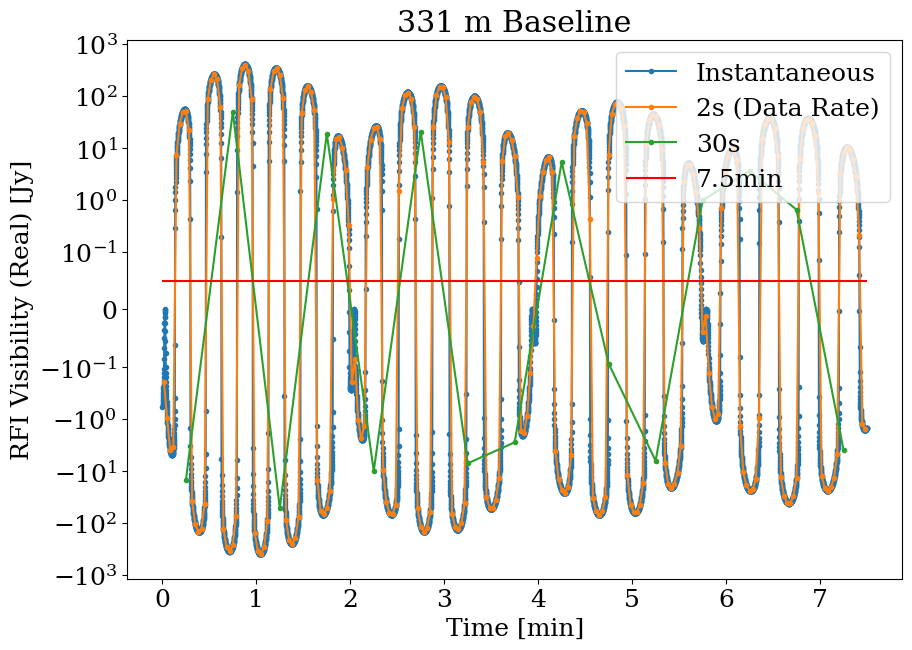

In [100]:
ax = plot_rfi_avg(times, v_rfi, bl_idx[0], save=False, close=False)


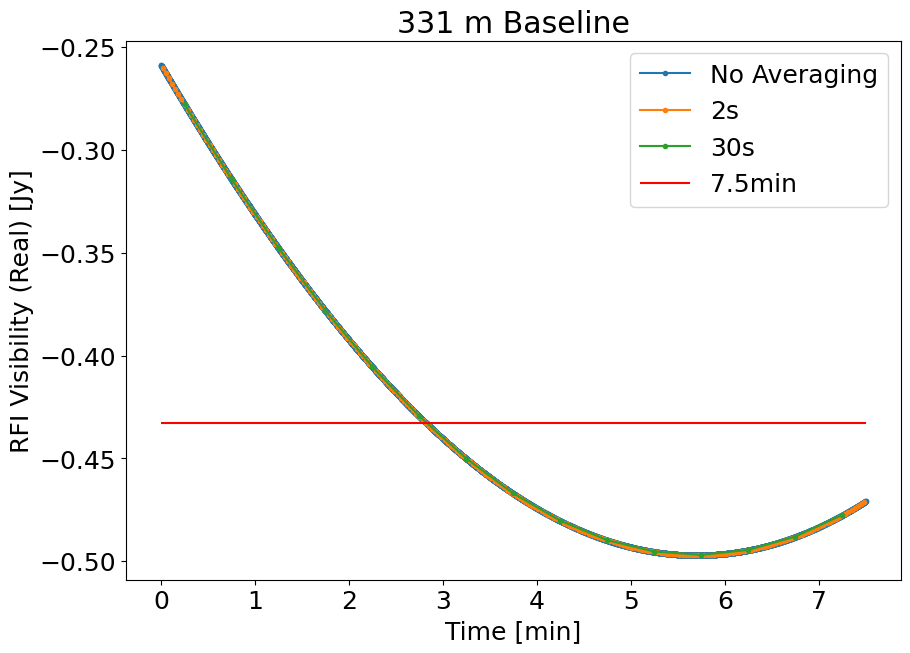

In [40]:
plot_rfi_avg(times, v_ast, bl_idx[0], save=False, close=False)

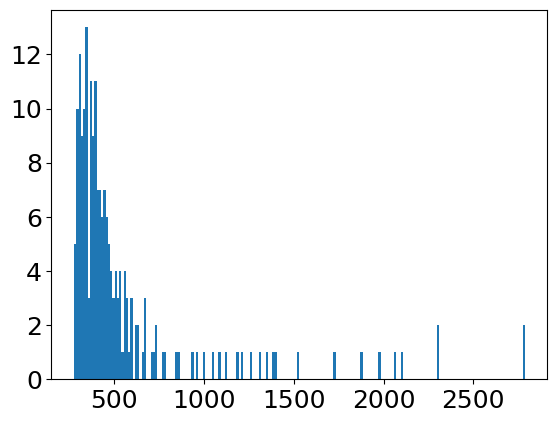

In [37]:
plt.hist(mag_uvw[bl_idx], bins=200);

In [86]:
n_time, n_freq, n_bl = 24, 128, 3

rfi_jan_m = np.random.rand(n_time, n_freq, n_bl)
rfi_jan_s = np.sqrt(rfi_jan_m)

rfi_dec_m = np.random.rand(n_time, n_freq, n_bl)

# time = 6-7 hr is larger in dec vs jan why?

jan_mean = rfi_jan_m.mean(axis=2)[6]
jan_std = rfi_jan_s.mean(axis=2)[6] # example bit iffy

dec_mean = rfi_dec_m.mean(axis=2)[6]

bias = np.abs(dec_mean-jan_mean)/jan_std

freqs = np.linspace(600, 900, 128)

f_idx = np.argsort(bias) 

plt.plot(freqs, bias)
for f in f_idx[-10:]:
    plt.plot(freqs[f], bias[f], 'ro')
    #plt.axvline(f, 0, 1, color='k')